In [10]:
library(rethinking)
data(rugged)
d <- rugged

In [11]:
d$log_gdp <- log(d$rgdppc_2000)

dd <- d[complete.cases(d$rgdppc_2000),]
d.A1 <- dd[dd$cont_africa == 1,]
d.A0 <- dd[dd$cont_africa == 0,]


In [23]:
head(dd)

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,⋯,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp
3,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670,-12.299,⋯,0,1,3610000,5.669,6.981,4.926,3.872,1223208,2.000,7.492609
5,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740,41.143,⋯,0,0,0,NA,NA,NA,NA,200000,100.000,8.216929
8,ARE,784,United Arab Emirates,0.769,0.316,2.112,0.191,6.142,8360,23.913,⋯,0,0,0,NA,NA,NA,NA,19200,0.000,9.933263
9,ARG,32,Argentina,0.775,0.220,2.268,0.226,9.407,273669,-35.396,⋯,0,0,0,NA,NA,NA,NA,276632,89.889,9.407032
10,ARM,51,Armenia,2.688,0.934,8.178,0.799,50.556,2820,40.294,⋯,0,0,0,NA,NA,NA,NA,105743,0.500,7.792343
12,ATG,28,Antigua and Barbuda,0.006,0.003,0.012,0.003,0.000,44,17.271,⋯,0,0,0,NA,NA,NA,NA,747,NA,9.212541


In [12]:
m7.1 <- map(
    alist(
        log_gdp ~ dnorm(mu, sigma),
        mu <- a + bR*rugged,
        a ~ dnorm(8,100),
        bR ~ dnorm(0,1),
        sigma ~ dunif(0,10)
    ),
    data = d.A1
)

In [13]:
m7.2 <- map(
    alist(
        log_gdp ~ dnorm(mu, sigma),
        mu <- a + bR*rugged,
        a ~ dnorm(8,100),
        bR ~ dnorm(0,1),
        sigma ~ dunif(0,10)
    ),
    data = d.A0
)

In [15]:
m7.3 <- map(
    alist(
        log_gdp ~ dnorm(mu, sigma),
        mu <- a + bR*rugged,
        a ~ dnorm(8,100),
        bR ~ dnorm(0,1),
        sigma ~ dunif(0,10)
    ),
    data = dd
)

In [16]:
m7.4 <- map(
    alist(
        log_gdp ~ dnorm(mu, sigma),
        mu <- a + bR*rugged + bA*cont_africa,
        a ~ dnorm(8,100),
        bR ~ dnorm(0,1),
        bA ~ dnorm(0,1),
        sigma ~ dunif(0,10)
    ),
    data = dd
)

In [17]:
compare(m7.3, m7.4)

      WAIC pWAIC dWAIC weight    SE   dSE
m7.4 476.3   4.4   0.0      1 15.33    NA
m7.3 539.9   2.8  63.6      0 13.35 15.17

In [22]:
rugged.seq <- seq(from = -1, to = 8, by = 0.25)

mu.NotAfrica <- link( m7.4, data=data.frame(cont_africa = 0, rugged = rugged.seq))
mu.Africa <- link( m7.4, data=data.frame(cont_africa = 1, rugged = rugged.seq))

mu.NotAfrica.mean <- apply(mu.NotAfrica, 2, mean)
mu.NotAfrica.PI <- apply(mu.NotAfrica, 2, PI, prob = 0.97)
mu.Africa.mean <- apply(mu.Africa, 2, mean)
mu.Africa.PI <- apply(mu.Africa, 2, PI, prob = 0.97)

[ 1000 / 1000 ]
[ 1000 / 1000 ]


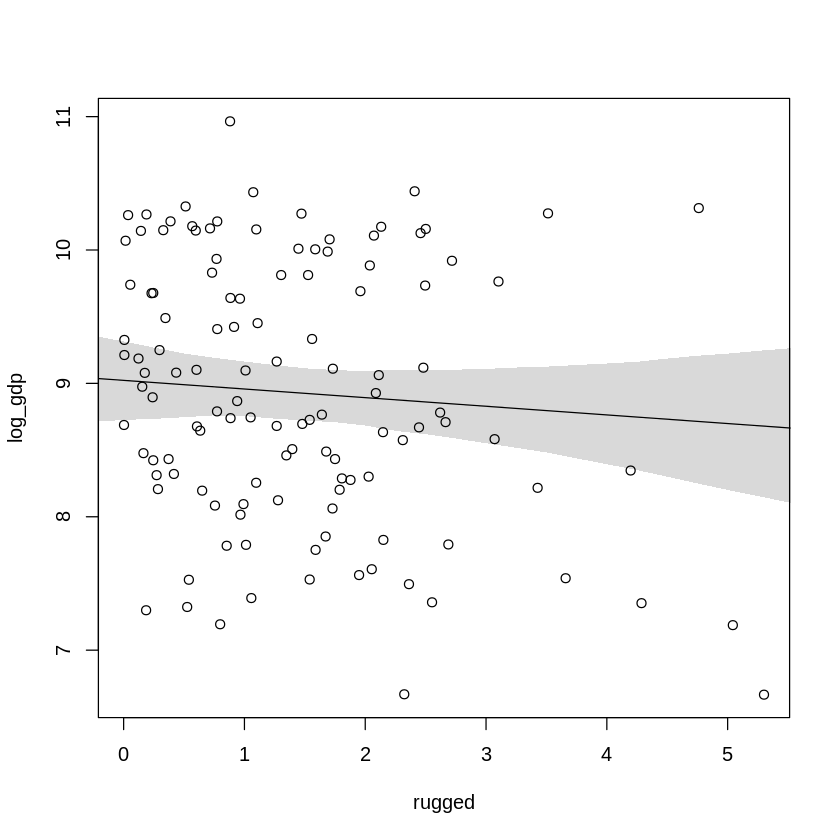

In [37]:
plot(log_gdp~rugged, data = d.A0)
lines(rugged.seq, mu.NotAfrica.mean)
shade(mu.NotAfrica.PI, rugged.seq)

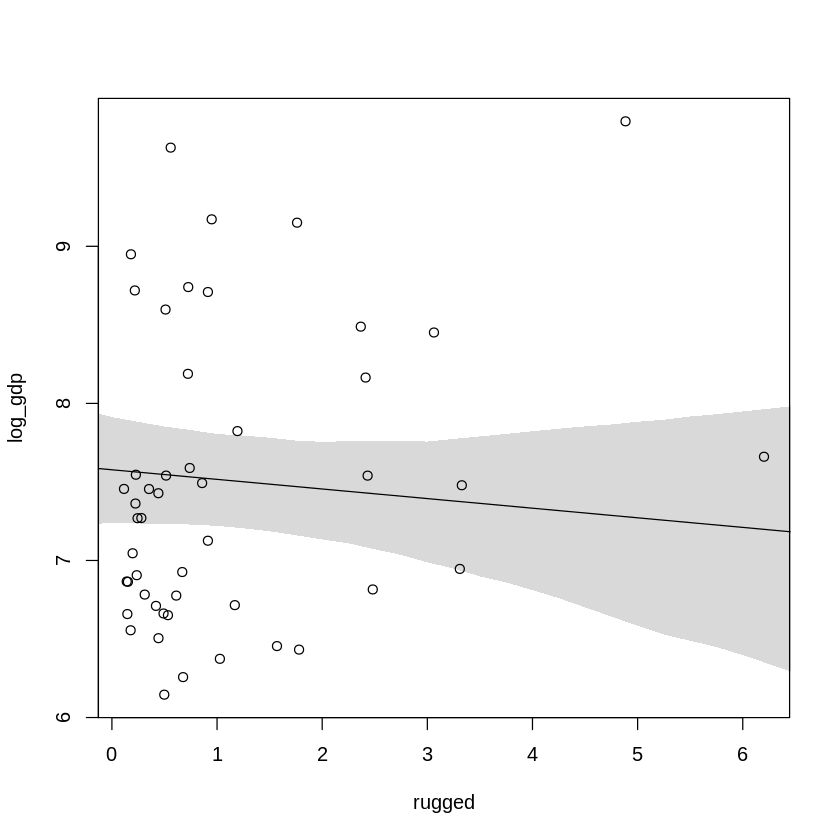

In [38]:
plot(log_gdp~rugged, data = d.A1)
lines(rugged.seq, mu.Africa.mean)
shade(mu.Africa.PI, rugged.seq)

In [53]:
m7.5 <- map(
    alist(
        log_gdp ~ dnorm(mu, sigma),
        mu <- a + gamma * rugged + bA*cont_africa,
        gamma <- bR + bAR*cont_africa,
        a ~ dnorm(8,100),
        bR ~ dnorm(0,1),
        bA ~ dnorm(0,1),
        bAR ~ dnorm(0,1),
        sigma ~ dunif(0,10)
    ),
    data = dd
)

In [54]:
compare(m7.3, m7.4, m7.5)

      WAIC pWAIC dWAIC weight    SE   dSE
m7.5 470.0   5.5   0.0   0.95 15.18    NA
m7.4 476.1   4.2   6.1   0.05 15.23  6.21
m7.3 539.5   2.7  69.5   0.00 13.29 15.21

In [55]:
stancode(m7.5)

data{
    int<lower=1> N;
    real log_gdp[N];
    real rugged[N];
    int cont_africa[N];
}
parameters{
    real a;
    real bR;
    real bA;
    real bAR;
    real<lower=0,upper=10> sigma;
}
model{
    vector[N] gamma;
    vector[N] mu;
    // sigma ~ uniform( 0 , 10 );
    bAR ~ normal( 0 , 1 );
    bA ~ normal( 0 , 1 );
    bR ~ normal( 0 , 1 );
    a ~ normal( 8 , 100 );
    for ( i in 1:N ) {
        gamma[i] = bR + bAR * cont_africa[i];
    }
    for ( i in 1:N ) {
        mu[i] = a + gamma[i] * rugged[i] + bA * cont_africa[i];
    }
    log_gdp ~ normal( mu , sigma );
}
generated quantities{
    vector[N] gamma;
    vector[N] mu;
    real dev;
    dev = 0;
    for ( i in 1:N ) {
        gamma[i] = bR + bAR * cont_africa[i];
    }
    for ( i in 1:N ) {
        mu[i] = a + gamma[i] * rugged[i] + bA * cont_africa[i];
    }
    dev = dev + (-2)*normal_lpdf( log_gdp | mu , sigma );
}
